In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from sbi.neural_nets.estimators import MixedDensityEstimator
from sbi.neural_nets.estimators.categorical_net import CategoricalMADE, CategoricalMassEstimator
from sbi.utils.torchutils import BoxUniform
import matplotlib.pyplot as plt
from sbi.inference import MNLE
from sbi.neural_nets.estimators.nflows_flow import NFlowsFlow
from sbi.neural_nets.net_builders.mdn import build_mdn
from sbi.neural_nets.net_builders.categorial import build_autoregressive_categoricalmassestimator, build_categoricalmassestimator
from sbi.neural_nets.net_builders.mnle import build_mnle
from sbi.analysis import pairplot

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [18]:
def toy_simulator(theta: torch.Tensor, centers: list[torch.Tensor]) -> torch.Tensor:
    batch_size, n_dimensions = theta.shape
    assert len(centers) == n_dimensions, "Number of center sets must match theta dimensions"
    
    # Calculate discrete classes by assiging to the closest center
    x_disc = torch.stack([
        torch.argmin(torch.abs(centers[i].unsqueeze(1) - theta[:, i].unsqueeze(0)), dim=0)
        for i in range(n_dimensions)
    ], dim=1)

    closest_centers = torch.stack([centers[i][x_disc[:, i]] for i in range(n_dimensions)], dim=1)
    # Add Gaussian noise to assigned class centers
    std = 0.4
    x_cont = closest_centers + std * torch.randn_like(closest_centers)
       
    return torch.cat([x_cont, x_disc], dim=1)

In [23]:
# THIS WORKS FOR 1D

torch.random.manual_seed(0)
centers = [
    torch.tensor([-0.5, 0.5]),
    # torch.tensor([-1.0, 0.0, 1.0]),
]

prior = BoxUniform(low=torch.tensor([-2.0]*len(centers)), high=torch.tensor([2.0]*len(centers)))
theta = prior.sample((10000,))
x = toy_simulator(theta, centers)
theta = torch.hstack([theta, torch.randn_like(theta)])

theta_o = prior.sample((1,))
x_o = toy_simulator(theta_o, centers)

cmade = build_autoregressive_categoricalmassestimator(x[:,-len(centers):], theta)
mlp = build_categoricalmassestimator(x[:,-len(centers):], theta)
cmade_mnle = build_mnle(x, theta, categorical_model="made")

# MNLE mixes up x,y (input and condition data!)
# Train MNLE and obtain MCMC-based posterior.
trainer = MNLE(density_estimator=lambda x,y: build_mnle(y,x,categorical_model="made"))
estimator = trainer.append_simulations(theta, x).train(training_batch_size=1000)

/tmp/ipykernel_706796/1950430755.py:17: UserWarning: Inferring categories from batch_x. Ensure all categories are present.
  cmade = build_autoregressive_categoricalmassestimator(x[:,-len(centers):], theta)
/tmp/ipykernel_706796/1950430755.py:19: UserWarning: The mixed neural likelihood estimator assumes that x contains continuous data in the first n-k columns (e.g., reaction times) and categorical data in the last k columns (e.g., corresponding choices). If this is not the case for the passed `x` do not use this function.
  cmade_mnle = build_mnle(x, theta, categorical_model="made")
/tmp/ipykernel_706796/1950430755.py:28: UserWarning: The mixed neural likelihood estimator assumes that x contains continuous data in the first n-k columns (e.g., reaction times) and categorical data in the last k columns (e.g., corresponding choices). If this is not the case for the passed `x` do not use this function.
  trainer = MNLE(density_estimator=lambda x,y: build_mnle(y,x,categorical_model="made")

 Neural network successfully converged after 20 epochs.

In [42]:
from sbi.inference import SNPE

In [45]:
# THIS WORKS FOR 2D

torch.random.manual_seed(0)
centers = [
    torch.tensor([-0.5, 0.5]),
    torch.tensor([-1.0, 0.0, 1.0]),
]

prior = BoxUniform(low=torch.tensor([-2.0]*len(centers)), high=torch.tensor([2.0]*len(centers)))
theta = prior.sample((20000,))
x = toy_simulator(theta, centers)

theta_o = prior.sample((1,))
x_o = toy_simulator(theta_o, centers)

cmade = build_autoregressive_categoricalmassestimator(x[:,-len(centers):], theta)
cmade_mnle = build_mnle(x, theta, categorical_model="made")

# Train MNLE and obtain MCMC-based posterior.
# trainer = MNLE(density_estimator=lambda x,y: build_mnle(y,x,categorical_model="made"))
trainer = SNPE()
estimator = trainer.append_simulations(theta=theta, x=x).train(training_batch_size=1000)

/tmp/ipykernel_706796/1968649956.py:16: UserWarning: Inferring categories from batch_x. Ensure all categories are present.
  cmade = build_autoregressive_categoricalmassestimator(x[:,-len(centers):], theta)
/tmp/ipykernel_706796/1968649956.py:17: UserWarning: The mixed neural likelihood estimator assumes that x contains continuous data in the first n-k columns (e.g., reaction times) and categorical data in the last k columns (e.g., corresponding choices). If this is not the case for the passed `x` do not use this function.
  cmade_mnle = build_mnle(x, theta, categorical_model="made")
/home/jnsbck/Uni/PhD/projects/sbi_hackathon/sbi_fork/sbi/neural_nets/net_builders/mnle.py:155: UserWarning: Inferring categories from batch_x. Ensure all categories are present.
  discrete_net = build_autoregressive_categoricalmassestimator(


 Training neural network. Epochs trained: 117

In [ ]:
snpe_posterior = trainer.build_posterior(prior=prior)
posterior_samples = snpe_posterior.sample((2000,), x=x_o)
pairplot(posterior_samples, limits=[[-2, 2], [-2, 2]], figsize=(5, 5), points=theta_o)

In [41]:
mcmc_kwargs = dict(
    num_chains=20,
    warmup_steps=50,
    method="slice_np_vectorized",
    init_strategy="proposal",
)

# Build posterior from the trained estimator and prior.
mnle_posterior = trainer.build_posterior(prior=prior)


torch.random.manual_seed(0)
theta_o = prior.sample((1,))
x_o = toy_simulator(theta_o, centers)

mnle_samples = mnle_posterior.sample((10000,), x=x_o, **mcmc_kwargs)

Running vectorized MCMC with 20 chains:   0%|          | 0/12000 [00:00<?, ?it/s]

KeyboardInterrupt: 

(<Figure size 500x500 with 4 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >],
        [<Axes: xlabel='dim 1'>, <Axes: xlabel='dim 2'>]], dtype=object))

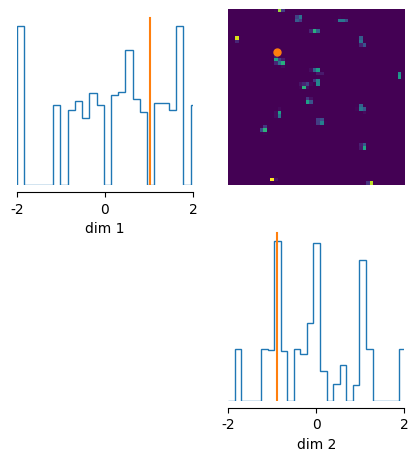

In [ ]:
pairplot(mnle_samples, limits=[[-2, 2], [-2, 2]], figsize=(5, 5), points=theta_o)